# Image Quality Metrics: PSNR and SSIM

This notebook explains two key metrics for evaluating super-resolution quality.

---

## PSNR (Peak Signal-to-Noise Ratio)

Measures pixel-wise reconstruction accuracy.

**Formula:**
$$\text{PSNR} = 20 \cdot \log_{10}\left(\frac{\text{MAX}}{\sqrt{\text{MSE}}}\right)$$

where MSE = Mean Squared Error between images.

**Interpretation:**
- Unit: Decibels (dB)
- Higher = better
- Typical SR range: 25-40 dB
- Limitation: Poor correlation with human perception

---

## SSIM (Structural Similarity Index)

Measures structural similarity considering luminance, contrast, and structure.

**Formula:**
$$\text{SSIM}(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$

**Interpretation:**
- Range: 0 to 1
- Closer to 1 = better
- Typical SR range: 0.90-0.99
- Better correlation with human perception than PSNR

---

In [60]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


In [61]:
# Load dataset
hr_dir = Path('./dataset/high_resolution')
lr_dir = Path('./dataset/low_resolution')

hr_images = sorted(list(hr_dir.glob('*.png')))
lr_images = sorted(list(lr_dir.glob('*.png')))

# Randomly select 5 samples
indices = random.sample(range(len(hr_images)), 5)
transform = transforms.ToTensor()

samples = []
for idx in indices:
    hr_img = Image.open(hr_images[idx]).convert('RGB')
    lr_img = Image.open(lr_images[idx]).convert('RGB')
    lr_img = lr_img.resize((256, 256), Image.BICUBIC)  # Upsample to 256x256
    
    samples.append({
        'lr': np.array(lr_img) / 255.0,
        'hr': np.array(hr_img) / 255.0
    })

print(f'Loaded 5 random samples')

Loaded 5 random samples


In [62]:
# Load U-Net model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super().__init__()
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.up1 = Up(256 + 128, 128)
        self.up2 = Up(128 + 64, 64)
        self.up3 = Up(64 + 32, 32)
        self.outc = nn.Conv2d(32, n_classes, kernel_size=1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        return self.outc(x)

model = UNet().to(device)
checkpoint = torch.load('./checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f'✓ Model loaded (epoch {checkpoint["epoch"]+1})')

✓ Model loaded (epoch 29)


In [63]:
# Generate super-resolved images
with torch.no_grad():
    for sample in samples:
        lr_tensor = torch.from_numpy(sample['lr'].transpose(2, 0, 1)).float().unsqueeze(0).to(device)
        sr_tensor = model(lr_tensor).squeeze(0).cpu()
        sample['sr'] = np.clip(sr_tensor.numpy().transpose(1, 2, 0), 0, 1)

print('✓ Generated SR images')

✓ Generated SR images


In [64]:
# Calculate metrics
for i, sample in enumerate(samples):
    # LR vs HR (baseline: bicubic)
    sample['psnr_lr'] = psnr(sample['hr'], sample['lr'], data_range=1.0)
    sample['ssim_lr'] = ssim(sample['hr'], sample['lr'], data_range=1.0, channel_axis=2)
    
    # SR vs HR (model)
    sample['psnr_sr'] = psnr(sample['hr'], sample['sr'], data_range=1.0)
    sample['ssim_sr'] = ssim(sample['hr'], sample['sr'], data_range=1.0, channel_axis=2)
    
    print(f'Sample {i+1}:')
    print(f'  Bicubic - PSNR: {sample["psnr_lr"]:.2f} dB, SSIM: {sample["ssim_lr"]:.4f}')
    print(f'  U-Net   - PSNR: {sample["psnr_sr"]:.2f} dB, SSIM: {sample["ssim_sr"]:.4f}')
    print(f'  Gain    - PSNR: +{sample["psnr_sr"] - sample["psnr_lr"]:.2f} dB, SSIM: +{sample["ssim_sr"] - sample["ssim_lr"]:.4f}\n')

Sample 1:
  Bicubic - PSNR: 27.03 dB, SSIM: 0.9624
  U-Net   - PSNR: 31.55 dB, SSIM: 0.9903
  Gain    - PSNR: +4.52 dB, SSIM: +0.0279

Sample 2:
  Bicubic - PSNR: 27.26 dB, SSIM: 0.9615
  U-Net   - PSNR: 34.30 dB, SSIM: 0.9922
  Gain    - PSNR: +7.03 dB, SSIM: +0.0308

Sample 3:
  Bicubic - PSNR: 27.27 dB, SSIM: 0.9459
  U-Net   - PSNR: 29.24 dB, SSIM: 0.9818
  Gain    - PSNR: +1.97 dB, SSIM: +0.0359

Sample 4:
  Bicubic - PSNR: 26.92 dB, SSIM: 0.9628
  U-Net   - PSNR: 30.79 dB, SSIM: 0.9890
  Gain    - PSNR: +3.87 dB, SSIM: +0.0262

Sample 5:
  Bicubic - PSNR: 28.55 dB, SSIM: 0.9712
  U-Net   - PSNR: 33.00 dB, SSIM: 0.9908
  Gain    - PSNR: +4.45 dB, SSIM: +0.0196



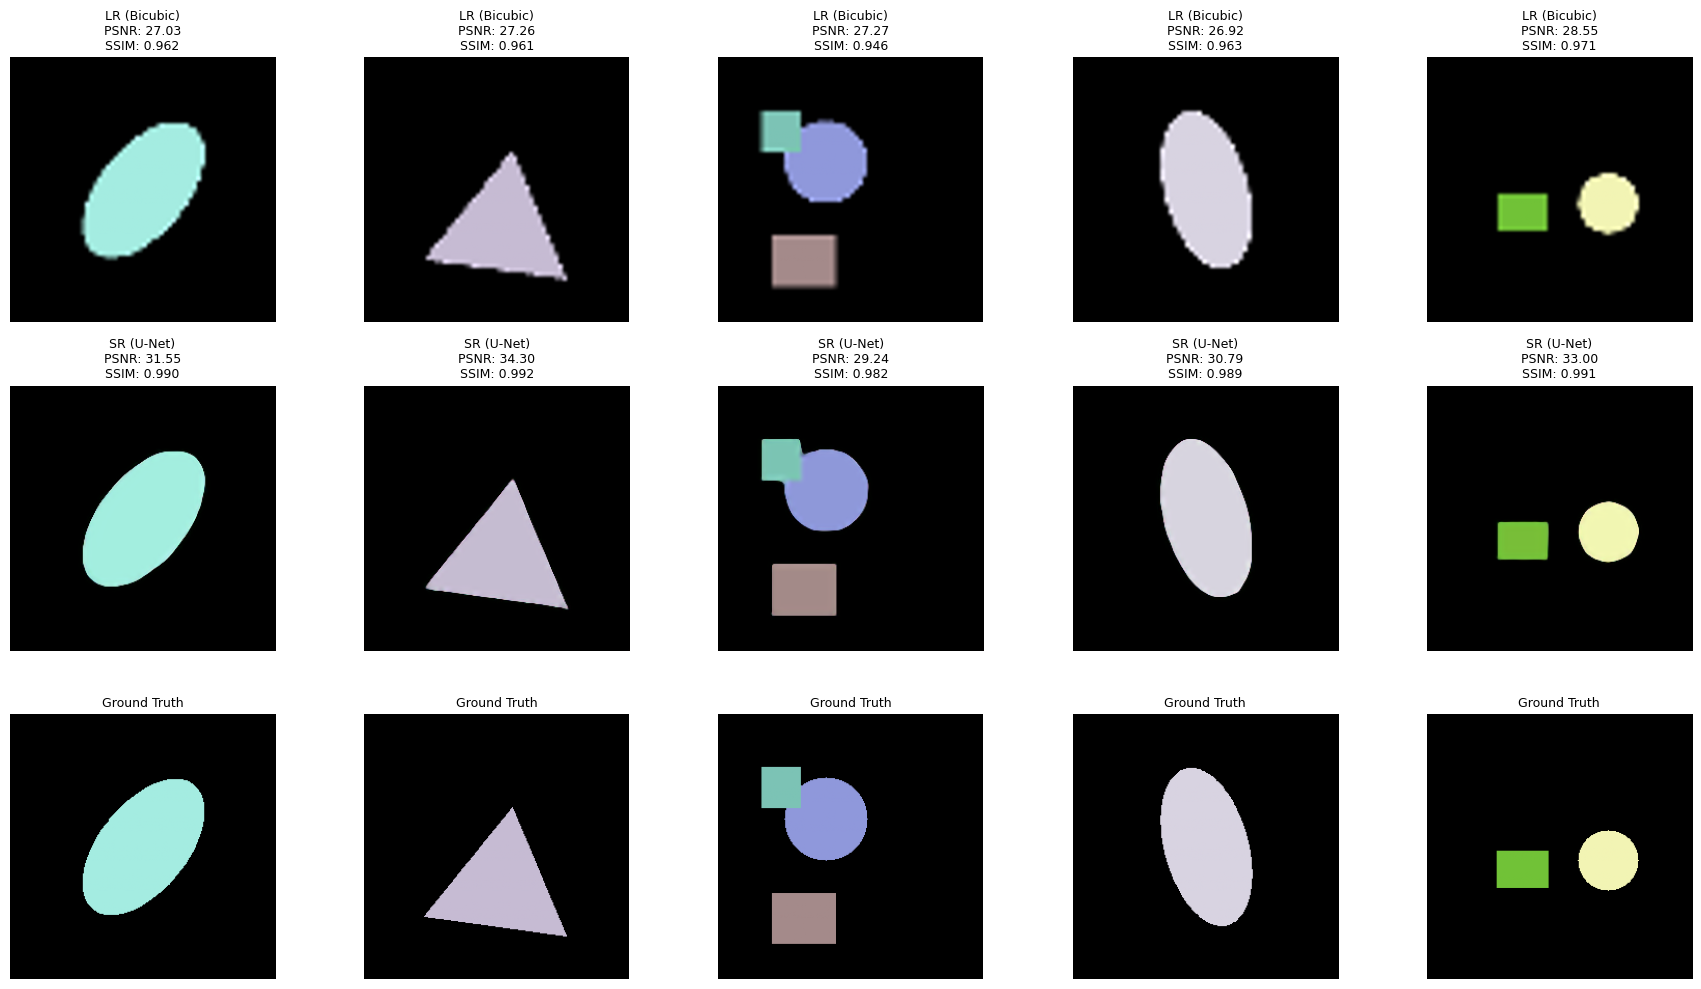

Saved: metrics_comparison.png


In [65]:
# Visualize comparison
fig, axes = plt.subplots(3, 5, figsize=(18, 10))

for i, sample in enumerate(samples):
    # Row 1: LR (Bicubic)
    axes[0, i].imshow(sample['lr'])
    axes[0, i].set_title(f'LR (Bicubic)\nPSNR: {sample["psnr_lr"]:.2f}\nSSIM: {sample["ssim_lr"]:.3f}', fontsize=9)
    axes[0, i].axis('off')
    
    # Row 2: SR (U-Net)
    axes[1, i].imshow(sample['sr'])
    axes[1, i].set_title(f'SR (U-Net)\nPSNR: {sample["psnr_sr"]:.2f}\nSSIM: {sample["ssim_sr"]:.3f}', fontsize=9)
    axes[1, i].axis('off')
    
    # Row 3: HR (Ground Truth)
    axes[2, i].imshow(sample['hr'])
    axes[2, i].set_title('Ground Truth', fontsize=9)
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig('./metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: metrics_comparison.png')

---

## What Happens When Images Don't Match?

To demonstrate the importance of these metrics, let's compare **two completely different images** (mismatched pairs). This shows what happens when reconstruction fails.

In [66]:
# Load two different random images (mismatched pairs)
mismatched_indices = random.sample(range(len(hr_images)), 4)

mismatch_samples = []

# Pair 1: Image A's LR/SR vs Image B's HR
idx_a, idx_b = mismatched_indices[0], mismatched_indices[1]
hr_a = Image.open(hr_images[idx_a]).convert('RGB')
lr_a = Image.open(lr_images[idx_a]).convert('RGB').resize((256, 256), Image.BICUBIC)
hr_b = Image.open(hr_images[idx_b]).convert('RGB')

lr_a_np = np.array(lr_a) / 255.0
hr_a_np = np.array(hr_a) / 255.0
hr_b_np = np.array(hr_b) / 255.0

# Generate SR for image A
with torch.no_grad():
    lr_tensor = torch.from_numpy(lr_a_np.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
    sr_tensor = model(lr_tensor).squeeze(0).cpu()
    sr_a_np = np.clip(sr_tensor.numpy().transpose(1, 2, 0), 0, 1)

# Calculate metrics: comparing image A's outputs with image B's HR (WRONG!)
psnr_mismatch_lr = psnr(hr_b_np, lr_a_np, data_range=1.0)
ssim_mismatch_lr = ssim(hr_b_np, lr_a_np, data_range=1.0, channel_axis=2)
psnr_mismatch_sr = psnr(hr_b_np, sr_a_np, data_range=1.0)
ssim_mismatch_sr = ssim(hr_b_np, sr_a_np, data_range=1.0, channel_axis=2)

mismatch_samples.append({
    'lr': lr_a_np,
    'sr': sr_a_np,
    'hr': hr_b_np,  # Different image!
    'psnr_lr': psnr_mismatch_lr,
    'ssim_lr': ssim_mismatch_lr,
    'psnr_sr': psnr_mismatch_sr,
    'ssim_sr': ssim_mismatch_sr
})

# Pair 2: Another mismatched pair
idx_c, idx_d = mismatched_indices[2], mismatched_indices[3]
hr_c = Image.open(hr_images[idx_c]).convert('RGB')
lr_c = Image.open(lr_images[idx_c]).convert('RGB').resize((256, 256), Image.BICUBIC)
hr_d = Image.open(hr_images[idx_d]).convert('RGB')

lr_c_np = np.array(lr_c) / 255.0
hr_c_np = np.array(hr_c) / 255.0
hr_d_np = np.array(hr_d) / 255.0

with torch.no_grad():
    lr_tensor = torch.from_numpy(lr_c_np.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
    sr_tensor = model(lr_tensor).squeeze(0).cpu()
    sr_c_np = np.clip(sr_tensor.numpy().transpose(1, 2, 0), 0, 1)

psnr_mismatch_lr2 = psnr(hr_d_np, lr_c_np, data_range=1.0)
ssim_mismatch_lr2 = ssim(hr_d_np, lr_c_np, data_range=1.0, channel_axis=2)
psnr_mismatch_sr2 = psnr(hr_d_np, sr_c_np, data_range=1.0)
ssim_mismatch_sr2 = ssim(hr_d_np, sr_c_np, data_range=1.0, channel_axis=2)

mismatch_samples.append({
    'lr': lr_c_np,
    'sr': sr_c_np,
    'hr': hr_d_np,
    'psnr_lr': psnr_mismatch_lr2,
    'ssim_lr': ssim_mismatch_lr2,
    'psnr_sr': psnr_mismatch_sr2,
    'ssim_sr': ssim_mismatch_sr2
})

print('Mismatched Pair 1:')
print(f'  LR (Image A) vs HR (Image B) - PSNR: {psnr_mismatch_lr:.2f} dB, SSIM: {ssim_mismatch_lr:.4f}')
print(f'  SR (Image A) vs HR (Image B) - PSNR: {psnr_mismatch_sr:.2f} dB, SSIM: {ssim_mismatch_sr:.4f}')
print(f'\nMismatched Pair 2:')
print(f'  LR (Image C) vs HR (Image D) - PSNR: {psnr_mismatch_lr2:.2f} dB, SSIM: {ssim_mismatch_lr2:.4f}')
print(f'  SR (Image C) vs HR (Image D) - PSNR: {psnr_mismatch_sr2:.2f} dB, SSIM: {ssim_mismatch_sr2:.4f}')
print(f'\n⚠️ Notice: Much lower PSNR and SSIM values!')

Mismatched Pair 1:
  LR (Image A) vs HR (Image B) - PSNR: 13.54 dB, SSIM: 0.8433
  SR (Image A) vs HR (Image B) - PSNR: 13.43 dB, SSIM: 0.8525

Mismatched Pair 2:
  LR (Image C) vs HR (Image D) - PSNR: 14.95 dB, SSIM: 0.8933
  SR (Image C) vs HR (Image D) - PSNR: 14.82 dB, SSIM: 0.9011

⚠️ Notice: Much lower PSNR and SSIM values!


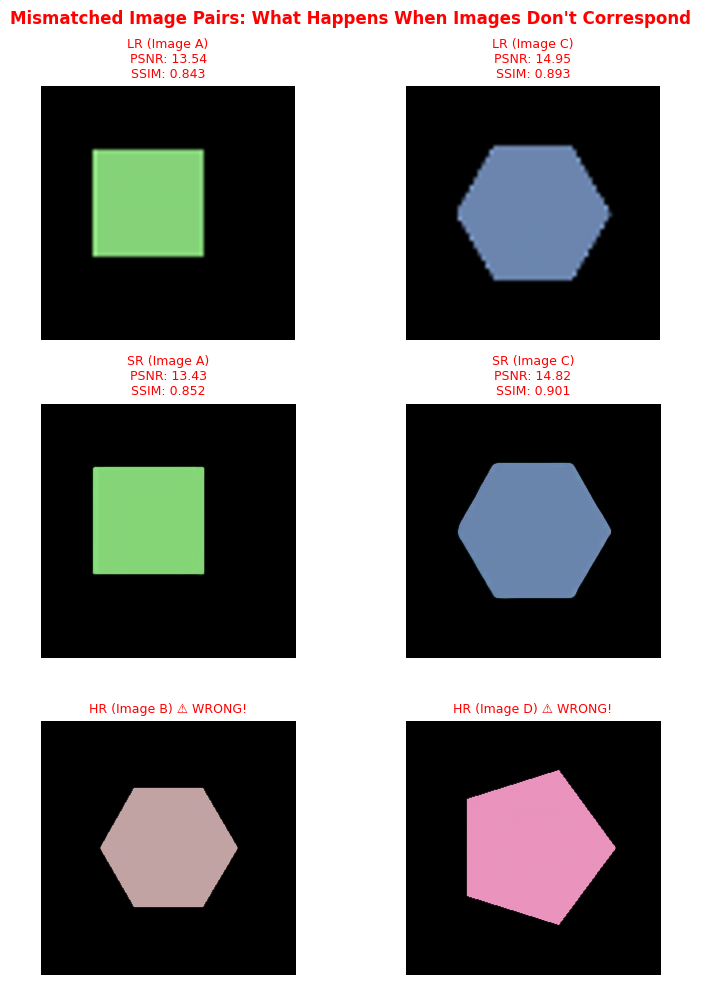

Saved: metrics_mismatch.png

Key Observation:
When comparing DIFFERENT images:
  - PSNR drops significantly (typically < 20 dB)
  - SSIM drops significantly (typically < 0.8)
  - Both metrics correctly identify the mismatch!


In [67]:
# Visualize mismatched pairs
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for i, sample in enumerate(mismatch_samples):
    # Row 1: LR (from one image)
    axes[0, i].imshow(sample['lr'])
    axes[0, i].set_title(f'LR (Image {chr(65+i*2)})\nPSNR: {sample["psnr_lr"]:.2f}\nSSIM: {sample["ssim_lr"]:.3f}', fontsize=9, color='red')
    axes[0, i].axis('off')
    
    # Row 2: SR (from same image as LR)
    axes[1, i].imshow(sample['sr'])
    axes[1, i].set_title(f'SR (Image {chr(65+i*2)})\nPSNR: {sample["psnr_sr"]:.2f}\nSSIM: {sample["ssim_sr"]:.3f}', fontsize=9, color='red')
    axes[1, i].axis('off')
    
    # Row 3: HR (from DIFFERENT image!)
    axes[2, i].imshow(sample['hr'])
    axes[2, i].set_title(f'HR (Image {chr(66+i*2)}) ⚠️ WRONG!', fontsize=9, color='red')
    axes[2, i].axis('off')

plt.suptitle('Mismatched Image Pairs: What Happens When Images Don\'t Correspond', fontsize=12, fontweight='bold', color='red')
plt.tight_layout()
plt.savefig('./metrics_mismatch.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: metrics_mismatch.png')
print('\n' + '='*60)
print('Key Observation:')
print('='*60)
print('When comparing DIFFERENT images:')
print('  - PSNR drops significantly (typically < 20 dB)')
print('  - SSIM drops significantly (typically < 0.8)')
print('  - Both metrics correctly identify the mismatch!')
print('='*60)

---

## ConvKAN Model Evaluation

Now let's test the ConvKAN model and compare its performance with U-Net.

In [68]:
# Load ConvKAN model
try:
    from convkan import ConvKAN, LayerNorm2D
    print("✓ ConvKAN imported successfully")
except ImportError:
    print("ERROR: convkan not installed. Install with: pip install convkan")
    raise

# Define ConvKAN architecture
class ConvKANResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvKAN(channels, channels, kernel_size=3, padding=1),
            LayerNorm2D(channels),
            ConvKAN(channels, channels, kernel_size=3, padding=1),
            LayerNorm2D(channels)
        )
    def forward(self, x):
        return x + self.block(x)

class ConvKAN_SR(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=16, n_res_blocks=2, upscale_factor=2):
        super().__init__()
        self.head = ConvKAN(in_channels, base_filters, kernel_size=3, padding=1)
        body = [ConvKANResBlock(base_filters) for _ in range(n_res_blocks)]
        self.body = nn.Sequential(*body)
        self.upsample = nn.Sequential(
            ConvKAN(base_filters, base_filters * (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor),
            LayerNorm2D(base_filters)
        )
        self.tail = nn.Conv2d(base_filters, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = self.head(x)
        res = x
        x = self.body(x)
        x = x + res
        x = self.upsample(x)
        x = self.tail(x)
        return x

# Load ConvKAN checkpoint
convkan_model = ConvKAN_SR().to(device)
convkan_checkpoint = torch.load('./checkpoints_convkan/convkan_best.pth', map_location=device)
convkan_model.load_state_dict(convkan_checkpoint['model_state_dict'])
convkan_model.eval()

print(f'✓ ConvKAN model loaded (epoch {convkan_checkpoint["epoch"]+1})')
print(f'  Validation loss: {convkan_checkpoint["val_loss"]:.6f}')

✓ ConvKAN imported successfully
✓ ConvKAN model loaded (epoch 48)
  Validation loss: 0.003870


In [69]:
# Generate ConvKAN SR images (using 128x128 input)
convkan_samples = []

for idx in indices:
    hr_img = Image.open(hr_images[idx]).convert('RGB')
    lr_img = Image.open(lr_images[idx]).convert('RGB')
    
    # ConvKAN expects 128x128 input (processes at this size, outputs 256x256)
    lr_128 = lr_img.resize((128, 128), Image.BICUBIC)
    
    # Also keep 256x256 bicubic for comparison
    lr_256 = lr_img.resize((256, 256), Image.BICUBIC)
    
    lr_128_np = np.array(lr_128) / 255.0
    lr_256_np = np.array(lr_256) / 255.0
    hr_np = np.array(hr_img) / 255.0
    
    # Generate SR with ConvKAN
    with torch.no_grad():
        lr_tensor = torch.from_numpy(lr_128_np.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
        sr_tensor = convkan_model(lr_tensor).squeeze(0).cpu()
        sr_convkan_np = np.clip(sr_tensor.numpy().transpose(1, 2, 0), 0, 1)
    
    convkan_samples.append({
        'lr': lr_256_np,  # 256x256 bicubic for fair comparison
        'sr_convkan': sr_convkan_np,  # ConvKAN output
        'hr': hr_np
    })

print('✓ Generated ConvKAN SR images')

✓ Generated ConvKAN SR images


In [70]:
# Calculate ConvKAN metrics and compare with U-Net
print('='*70)
print('Model Performance Comparison: U-Net vs ConvKAN')
print('='*70)

for i in range(len(samples)):
    # Calculate ConvKAN metrics
    psnr_convkan = psnr(convkan_samples[i]['hr'], convkan_samples[i]['sr_convkan'], data_range=1.0)
    ssim_convkan = ssim(convkan_samples[i]['hr'], convkan_samples[i]['sr_convkan'], data_range=1.0, channel_axis=2)
    
    # Get U-Net metrics from earlier
    psnr_unet = samples[i]['psnr_sr']
    ssim_unet = samples[i]['ssim_sr']
    psnr_bicubic = samples[i]['psnr_lr']
    ssim_bicubic = samples[i]['ssim_lr']
    
    print(f'\nSample {i+1}:')
    print(f'  Bicubic - PSNR: {psnr_bicubic:.2f} dB, SSIM: {ssim_bicubic:.4f}')
    print(f'  U-Net   - PSNR: {psnr_unet:.2f} dB, SSIM: {ssim_unet:.4f}')
    print(f'  ConvKAN - PSNR: {psnr_convkan:.2f} dB, SSIM: {ssim_convkan:.4f}')
    
    # Determine winner
    if psnr_convkan > psnr_unet:
        print(f'  Winner: ConvKAN (+{psnr_convkan - psnr_unet:.2f} dB)')
    else:
        print(f'  Winner: U-Net (+{psnr_unet - psnr_convkan:.2f} dB)')
    
    # Store metrics for visualization
    convkan_samples[i]['psnr'] = psnr_convkan
    convkan_samples[i]['ssim'] = ssim_convkan

print('\n' + '='*70)

Model Performance Comparison: U-Net vs ConvKAN

Sample 1:
  Bicubic - PSNR: 27.03 dB, SSIM: 0.9624
  U-Net   - PSNR: 31.55 dB, SSIM: 0.9903
  ConvKAN - PSNR: 29.49 dB, SSIM: 0.9831
  Winner: U-Net (+2.07 dB)

Sample 2:
  Bicubic - PSNR: 27.26 dB, SSIM: 0.9615
  U-Net   - PSNR: 34.30 dB, SSIM: 0.9922
  ConvKAN - PSNR: 30.00 dB, SSIM: 0.9835
  Winner: U-Net (+4.29 dB)

Sample 3:
  Bicubic - PSNR: 27.27 dB, SSIM: 0.9459
  U-Net   - PSNR: 29.24 dB, SSIM: 0.9818
  ConvKAN - PSNR: 29.01 dB, SSIM: 0.9776
  Winner: U-Net (+0.23 dB)

Sample 4:
  Bicubic - PSNR: 26.92 dB, SSIM: 0.9628
  U-Net   - PSNR: 30.79 dB, SSIM: 0.9890
  ConvKAN - PSNR: 29.29 dB, SSIM: 0.9835
  Winner: U-Net (+1.50 dB)

Sample 5:
  Bicubic - PSNR: 28.55 dB, SSIM: 0.9712
  U-Net   - PSNR: 33.00 dB, SSIM: 0.9908
  ConvKAN - PSNR: 30.72 dB, SSIM: 0.9848
  Winner: U-Net (+2.29 dB)



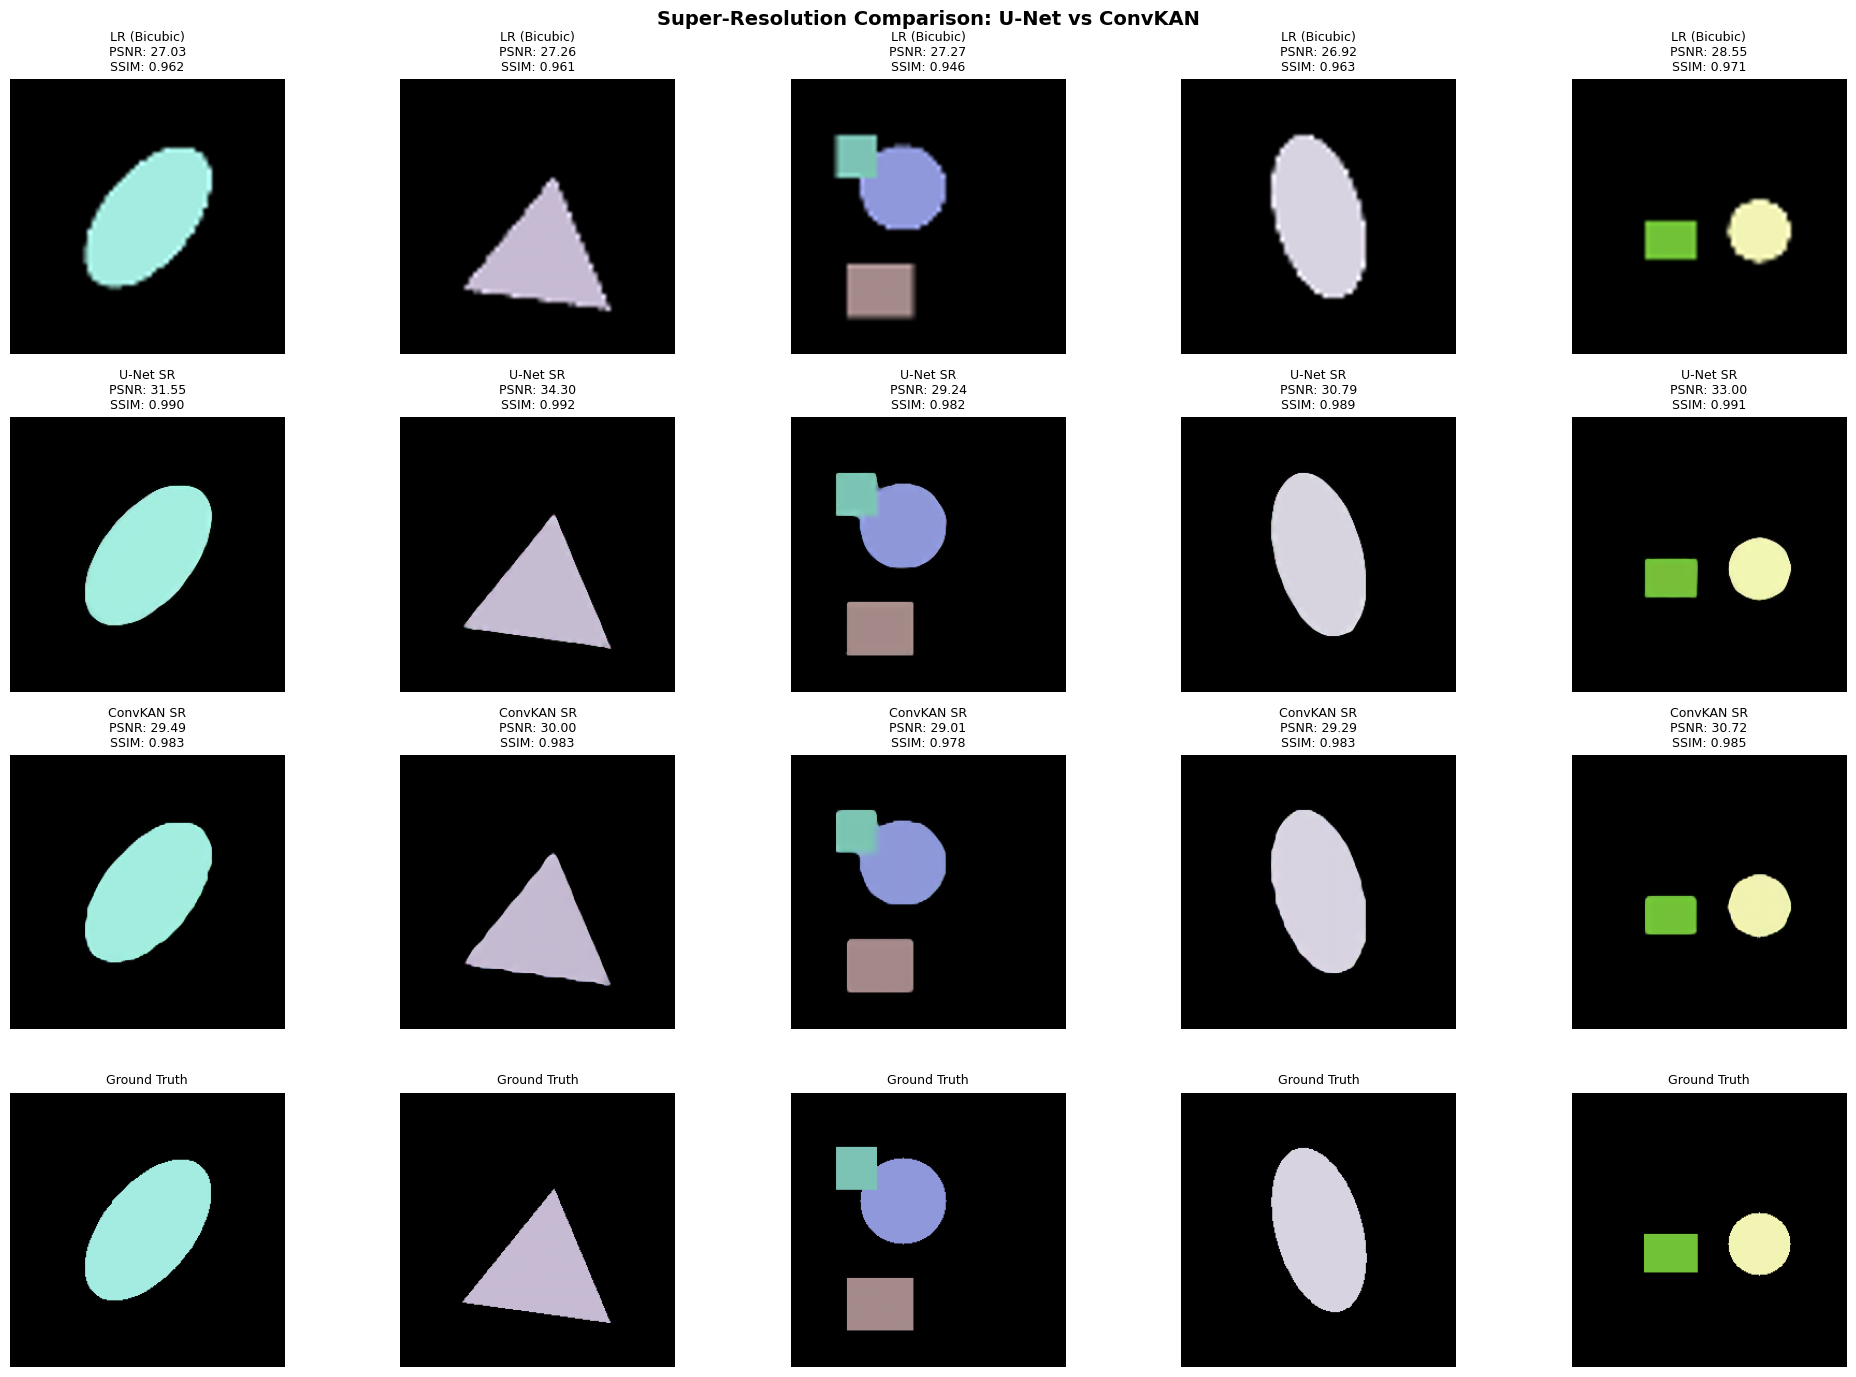

Saved: metrics_unet_vs_convkan.png


In [71]:
# Visualize U-Net vs ConvKAN comparison
fig, axes = plt.subplots(4, 5, figsize=(20, 14))

for i in range(5):
    # Row 1: LR (Bicubic)
    axes[0, i].imshow(samples[i]['lr'])
    axes[0, i].set_title(f'LR (Bicubic)\nPSNR: {samples[i]["psnr_lr"]:.2f}\nSSIM: {samples[i]["ssim_lr"]:.3f}', fontsize=9)
    axes[0, i].axis('off')
    
    # Row 2: U-Net SR
    axes[1, i].imshow(samples[i]['sr'])
    axes[1, i].set_title(f'U-Net SR\nPSNR: {samples[i]["psnr_sr"]:.2f}\nSSIM: {samples[i]["ssim_sr"]:.3f}', fontsize=9)
    axes[1, i].axis('off')
    
    # Row 3: ConvKAN SR
    axes[2, i].imshow(convkan_samples[i]['sr_convkan'])
    axes[2, i].set_title(f'ConvKAN SR\nPSNR: {convkan_samples[i]["psnr"]:.2f}\nSSIM: {convkan_samples[i]["ssim"]:.3f}', fontsize=9)
    axes[2, i].axis('off')
    
    # Row 4: Ground Truth
    axes[3, i].imshow(samples[i]['hr'])
    axes[3, i].set_title('Ground Truth', fontsize=9)
    axes[3, i].axis('off')

plt.suptitle('Super-Resolution Comparison: U-Net vs ConvKAN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./metrics_unet_vs_convkan.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: metrics_unet_vs_convkan.png')

### Summary Statistics

Let's calculate average performance across all 5 samples.

In [72]:
# Calculate average metrics
avg_psnr_bicubic = np.mean([s['psnr_lr'] for s in samples])
avg_ssim_bicubic = np.mean([s['ssim_lr'] for s in samples])
avg_psnr_unet = np.mean([s['psnr_sr'] for s in samples])
avg_ssim_unet = np.mean([s['ssim_sr'] for s in samples])
avg_psnr_convkan = np.mean([s['psnr'] for s in convkan_samples])
avg_ssim_convkan = np.mean([s['ssim'] for s in convkan_samples])

print('='*70)
print('Average Performance Across 5 Samples')
print('='*70)
print(f'\nBicubic Baseline:')
print(f'  PSNR: {avg_psnr_bicubic:.2f} dB')
print(f'  SSIM: {avg_ssim_bicubic:.4f}')

print(f'\nU-Net:')
print(f'  PSNR: {avg_psnr_unet:.2f} dB  (Gain: +{avg_psnr_unet - avg_psnr_bicubic:.2f} dB)')
print(f'  SSIM: {avg_ssim_unet:.4f}  (Gain: +{avg_ssim_unet - avg_ssim_bicubic:.4f})')

print(f'\nConvKAN:')
print(f'  PSNR: {avg_psnr_convkan:.2f} dB  (Gain: +{avg_psnr_convkan - avg_psnr_bicubic:.2f} dB)')
print(f'  SSIM: {avg_ssim_convkan:.4f}  (Gain: +{avg_ssim_convkan - avg_ssim_bicubic:.4f})')

print(f'\n' + '-'*70)
print(f'U-Net vs ConvKAN:')
if avg_psnr_convkan > avg_psnr_unet:
    print(f'  ConvKAN wins by {avg_psnr_convkan - avg_psnr_unet:.2f} dB (PSNR)')
else:
    print(f'  U-Net wins by {avg_psnr_unet - avg_psnr_convkan:.2f} dB (PSNR)')

if avg_ssim_convkan > avg_ssim_unet:
    print(f'  ConvKAN wins by {avg_ssim_convkan - avg_ssim_unet:.4f} (SSIM)')
else:
    print(f'  U-Net wins by {avg_ssim_unet - avg_ssim_convkan:.4f} (SSIM)')
print('='*70)

Average Performance Across 5 Samples

Bicubic Baseline:
  PSNR: 27.41 dB
  SSIM: 0.9608

U-Net:
  PSNR: 31.78 dB  (Gain: +4.37 dB)
  SSIM: 0.9888  (Gain: +0.0281)

ConvKAN:
  PSNR: 29.70 dB  (Gain: +2.29 dB)
  SSIM: 0.9825  (Gain: +0.0217)

----------------------------------------------------------------------
U-Net vs ConvKAN:
  U-Net wins by 2.08 dB (PSNR)
  U-Net wins by 0.0063 (SSIM)
